In [82]:
import geopandas
from metpy.plots import MapPanel, PanelContainer, PlotGeometry

import requests
import os
import pandas as pd

from metpy.plots import USCOUNTIES
import cartopy.feature as cfeat

In [95]:
WFO = 'GRR'
Begins = '2023-06-25T12:00:00Z'
Ends = '2023-06-26T12:00:00Z'
TitleDate = '6/25/2023'

Warn = geopandas.read_file('https://mesonet.agron.iastate.edu/api/1/cow.json?wfo='+WFO+'&begints='+Begins+'&endts='+Ends+'&hailsize=1&wind=58&phenomena=TO&phenomena=SV&phenomena=MA&phenomena=FF&phenomena=DS&lsrtype=T&lsrtype=D&lsrtype=H&lsrtype=G&lsrtype=MA&lsrtype=FF&lsrtype=DS&lsrbuffer=15&warningbuffer=1')
Warn

,id,year,wfo,phenomena,eventid,issue,expire,statuses,fcster,significance,...,parea,ar_ugcname,status,stormreports,stormreports_all,verify,lead0,areaverify,sharedborder,geometry
0,2023GRR16MAW1,2023,GRR,MA,16,2023-06-25 19:10:00+00:00,2023-06-25 20:26:00+00:00,CAN,DUKE,W,...,5934.550602,[Lake Michigan from Holland to Grand Haven MI ...,CAN,"0,1","0,1",True,4,350.102010,234044.807480,"MULTIPOLYGON (((-86.28000 42.42000, -86.36000 ..."
1,2023GRR30SVW1,2023,GRR,SV,30,2023-06-25 20:10:00+00:00,2023-06-25 21:01:00+00:00,CAN,DUKE,W,...,1919.828232,"[Barry MI, Calhoun MI, Kalamazoo MI, Eaton MI]",CAN,"2,7,9","2,7,9",True,10,1266.080212,0.000000,"MULTIPOLYGON (((-85.10000 42.14000, -85.42000 ..."
2,2023GRR31SVW1,2023,GRR,SV,31,2023-06-25 20:36:00+00:00,2023-06-25 21:30:00+00:00,EXP,DUKE,W,...,2748.946071,"[Newaygo MI, Mecosta MI, Lake MI, Osceola MI]",EXP,15,15,True,40,705.723410,3868.691271,"MULTIPOLYGON (((-85.56000 43.47000, -86.00000 ..."
3,2023GRR32SVW1,2023,GRR,SV,32,2023-06-25 20:47:00+00:00,2023-06-25 21:30:00+00:00,CON,DUKE,W,...,1598.922594,"[Kent MI, Montcalm MI]",CON,11,11,True,8,551.568316,77382.112691,"MULTIPOLYGON (((-85.26000 43.12000, -85.31000 ..."
4,2023GRR33SVW1,2023,GRR,SV,33,2023-06-25 20:49:00+00:00,2023-06-25 21:30:00+00:00,EXP,DUKE,W,...,867.342786,"[Lake MI, Mason MI]",EXP,12,12,True,11,575.957438,53346.239339,"MULTIPOLYGON (((-85.98000 44.16000, -85.83000 ..."
5,2023GRR34SVW1,2023,GRR,SV,34,2023-06-25 20:53:00+00:00,2023-06-25 21:39:00+00:00,CAN,DUKE,W,...,2124.735059,"[Ionia MI, Barry MI, Eaton MI, Clinton MI]",CAN,"13,18","13,18",True,7,1097.076051,50856.558870,"MULTIPOLYGON (((-84.82000 42.60000, -85.18000 ..."
6,2023GRR35SVW1,2023,GRR,SV,35,2023-06-25 21:03:00+00:00,2023-06-25 22:00:00+00:00,EXP,DUKE,W,...,3330.118695,"[Jackson MI, Calhoun MI, Eaton MI, Ingham MI]",EXP,"14,20","14,20",True,12,1242.458638,142427.312849,"MULTIPOLYGON (((-84.13000 42.08000, -84.74000 ..."
7,2023GRR36SVW1,2023,GRR,SV,36,2023-06-25 21:08:00+00:00,2023-06-25 22:02:00+00:00,CAN,DUKE,W,...,1466.049032,[Mecosta MI],CAN,"16,17","16,17",True,17,783.346622,153191.322590,"MULTIPOLYGON (((-85.09000 43.81000, -85.08000 ..."
8,2023GRR37SVW1,2023,GRR,SV,37,2023-06-25 21:32:00+00:00,2023-06-25 22:30:00+00:00,EXP,DUKE,W,...,3622.326902,"[Montcalm MI, Isabella MI, Gratiot MI]",EXP,21,21,True,26,560.616787,231156.050072,"MULTIPOLYGON (((-85.00000 43.12000, -85.14000 ..."


In [96]:
i = Warn['phenomena']
color=[]
q = 0
while q < len(i):
    if i[q] == 'SV':
        color.append('Yellow')
    elif i[q] == 'TO':
         color.append('Red')
    elif i[q] =='FF':
        color.append('Green')
    elif i[q] == 'MA':
         color.append('Orange')
    elif i[q] =='DS':
        color.append('Brown')
    q+=1
Warn['fill'] = color
Warn['stroke']='Black'

In [97]:
geo = PlotGeometry()
geo.geometry = Warn['geometry']
geo.fill = Warn['fill']
geo.stroke = Warn['stroke']
geo.labels = Warn['eventid']
geo.label_fontsize = 'large'

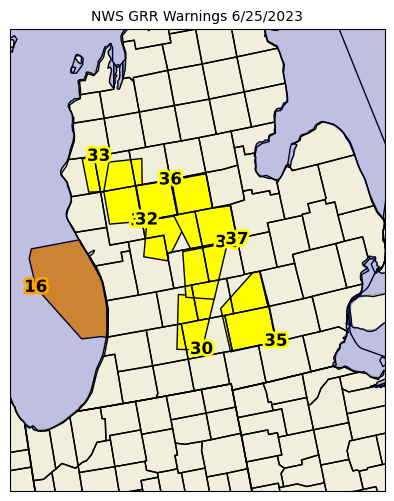

In [98]:
lake_50m = cfeat.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor='blue',
                                        facecolor='blue', alpha=0.2)
panel = MapPanel()
panel.title = 'NWS '+WFO+' Warnings '+ TitleDate
panel.area = [-87, -83, 41, 45]
#panel.area = [-110, -102, 37, 41]
panel.projection = 'lcc'
panel.layers = ['land', 'ocean', 'states', 'coastline', 'borders', 'USCOUNTIES', lake_50m]
panel.plots = [geo]

pc = PanelContainer()
pc.size = (10, 6)
pc.panels = [panel]
pc.show()